In [1]:
# Import packages 
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import cv2

from tqdm.auto import tqdm
from ipywidgets import FloatProgress
from scipy import ndimage
from PIL import Image
from importlib import reload

# append path
sys.path.append('../')

# custom
import utils.BuildWNet as BuildWNet
from utils.GetLowestGPU import GetLowestGPU
from utils.WNetTileGenerator import TileGenerator
from utils.Metrics import iou
from utils.AreaCalc import area_calc
import utils.SegmentImage as SegmentImage
import utils.MeasureLeaves as MeasureLeaves

device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 03312MiB / 40537MiB
  1  | 02574MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 34030MiB / 40537MiB
  5  | 34110MiB / 40537MiB
  6  | 34108MiB / 40537MiB
  7  | 33966MiB / 40537MiB
---------------------------
 Device set to cuda:2
---------------------------


In [5]:
# define paths

image_path = "../data/test/images/"
mask_path = "../data/test/masks/"
pred_path = "../data/test/predictions/"
rec_path = "../data/test/reconstructions/"

# load image data
image_names = glob.glob(mask_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

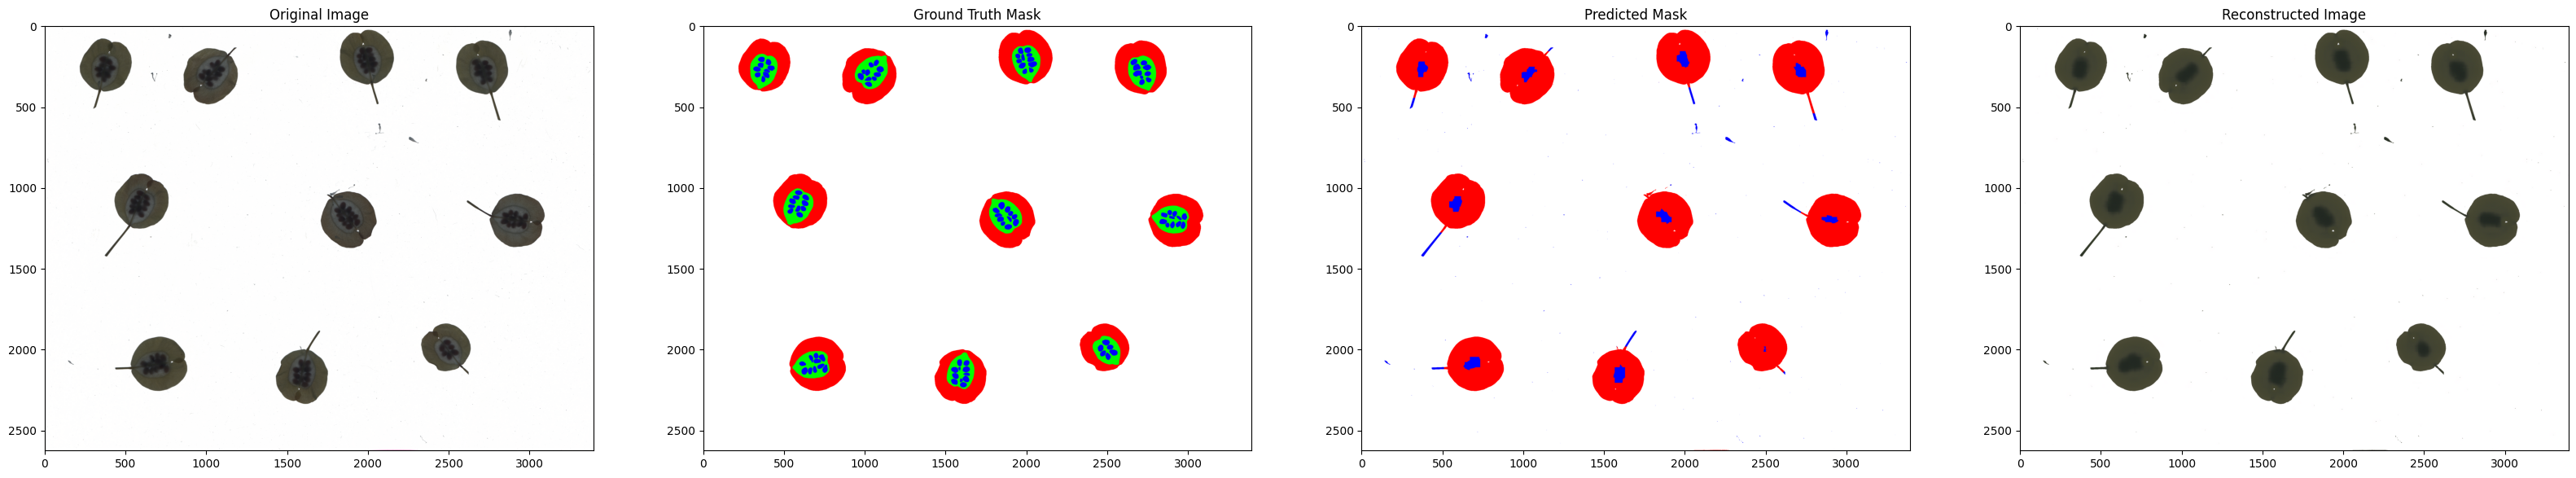

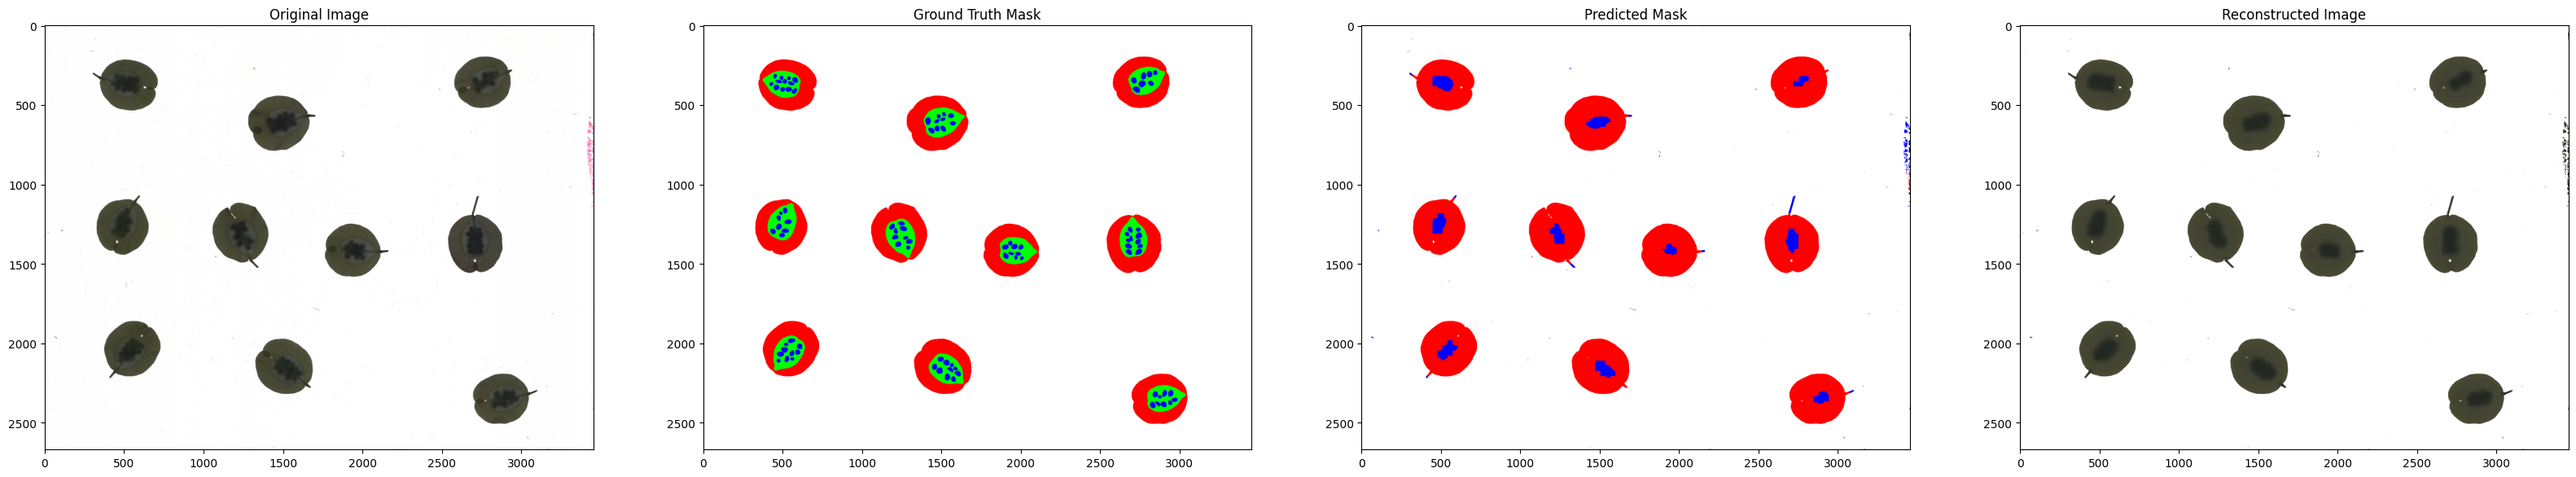

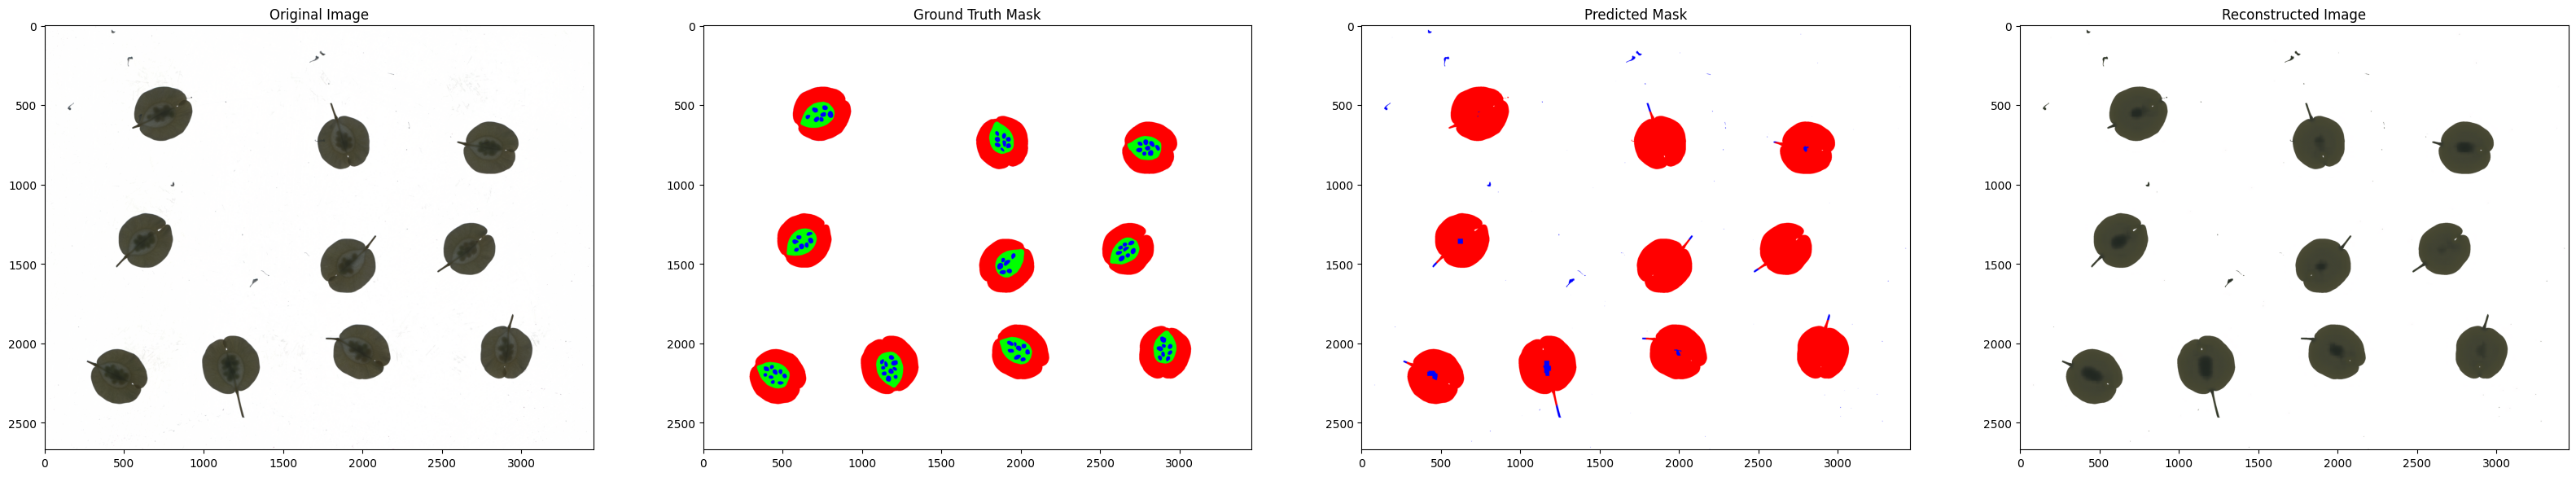

Average Jaccard Distance (IoU) for wing: 0.9723

Average Jaccard Distance (IoU) for envelope: 0.1369

Average Jaccard Distance (IoU) for seeds: 0.9883



In [15]:
wing_ious = []
env_ious = []
seed_ious = []

# post processing
for image_name in image_names:

    # load image, mask, pred, rec
    image = Image.open(image_path + image_name)
    image = np.array(image) / 255

    mask = Image.open(mask_path + image_name)
    mask = np.array(mask) / 255
    mask[mask.sum(axis=2) == 0] = 1

    pred = Image.open(pred_path + "pred_" + image_name)
    pred = np.array(pred) / 255

    rec = Image.open(rec_path + "rec_" + image_name)
    rec = np.array(rec) / 255

    pred[pred.sum(axis=2) == 3] = 0
    pred[pred[:,:,1] == 1] = 1
    pred[pred[:,:,2] == 1] = 1

    # convert black px to blue px
    pred[pred.sum(-1) == 0] = [0, 0, 1]

    wing_gt = mask[:, :, 0] == 1
    wing_pred = pred[:, :, 0] == 1
    wing_iou = iou(wing_gt, wing_pred)
    wing_ious.append(wing_iou)

    env_gt = mask[:, :, 1:].sum(-1) == 1 
    env_pred = pred[:, :, 1:].sum(-1) == 1  
    env_iou = iou(env_gt, env_pred)
    env_ious.append(env_iou)

    seed_gt = mask[:, :, 2] == 1
    seed_pred = pred[:, :, 2] == 1
    seed_iou = iou(seed_gt, seed_pred)
    seed_ious.append(seed_iou)

    # plot the image and prediction together
    fig, ax = plt.subplots(1, 4, figsize=(40, 20))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")

    # set mask bg to white and overlay on image
    ax[1].imshow(mask)
    ax[1].set_title("Ground Truth Mask")

    ax[2].imshow(pred)
    ax[2].set_title("Predicted Mask")

    ax[3].imshow(rec)
    ax[3].set_title("Reconstructed Image")
    plt.show()

avg_wing = np.mean(wing_ious)
avg_env = np.mean(env_ious)
avg_seed = np.mean(seed_ious)

print(f"Average Jaccard Distance (IoU) for wing: {avg_wing:.4f}\n")
print(f"Average Jaccard Distance (IoU) for envelope: {avg_env:.4f}\n")
print(f"Average Jaccard Distance (IoU) for seeds: {avg_seed:.4f}\n")